In [46]:
import numpy as np
import math,struct,pickle
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import copy

In [47]:
def bypass(x):
    return x
def tanh(x):
    return np.tanh(x)
def softmax(x):
    exp=np.exp(x-x.max())
    return exp/exp.sum()

def d_softmax(data):
    sm=softmax(data)
    return np.diag(sm)-np.outer(sm,sm)

# def d_tanh(data):
#     return np.diag(1/(np.cosh(data))**2)
def d_tanh(data):
    return 1/(np.cosh(data))**2
def d_bypass(x):
    return 1

differential={softmax:d_softmax,tanh:d_tanh,bypass:d_bypass}
d_type={bypass:'times',softmax:'dot',tanh:'times'}

In [48]:
dimensions=[28*28,100,10]
activation=[bypass,tanh,softmax]
distribution=[
    {}, # leave it empty!!
    {'b':[0,0],'w':[-math.sqrt(6/(dimensions[0]+dimensions[1])),math.sqrt(6/(dimensions[0]+dimensions[1]))]},
    {'b':[0,0],'w':[-math.sqrt(6/(dimensions[1]+dimensions[2])),math.sqrt(6/(dimensions[1]+dimensions[2]))]},
]

In [49]:
def init_parameters_b(layer):
    dist=distribution[layer]['b']
    return np.random.rand(dimensions[layer])*(dist[1]-dist[0])+dist[0]
def init_parameters_w(layer):
    dist=distribution[layer]['w']
    return np.random.rand(dimensions[layer-1],dimensions[layer])*(dist[1]-dist[0])+dist[0]
def init_parameters():
    parameter=[]
    for i in range(len(distribution)):
        layer_parameter={}
        for j in distribution[i].keys():
            if j=='b':
                layer_parameter['b']=init_parameters_b(i)
                continue
            if j=='w':
                layer_parameter['w']=init_parameters_w(i)
                continue
        parameter.append(layer_parameter)
    return parameter

In [50]:
def predict(img,parameters):
    l_in=img
    l_out=activation[0](l_in)
    for layer in range(1,len(dimensions)):
        l_in=np.dot(l_out,parameters[layer]['w'])+parameters[layer]['b']
        l_out=activation[layer](l_in)
    return l_out

In [51]:
dataset_path=Path('./MNIST')
train_img_path=dataset_path/'train-images.idx3-ubyte'
train_lab_path=dataset_path/'train-labels.idx1-ubyte'
test_img_path=dataset_path/'t10k-images.idx3-ubyte'
test_lab_path=dataset_path/'t10k-labels.idx1-ubyte'

In [52]:
train_num=50000
valid_num=10000
test_num=10000

with open(train_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    tmp_img=np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)/255
    train_img=tmp_img[:train_num]
    valid_img=tmp_img[train_num:]
    
with open(test_img_path,'rb') as f:
    struct.unpack('>4i',f.read(16))
    test_img=np.fromfile(f,dtype=np.uint8).reshape(-1,28*28)/255

with open(train_lab_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    tmp_lab=np.fromfile(f,dtype=np.uint8)
    train_lab=tmp_lab[:train_num]
    valid_lab=tmp_lab[train_num:]
    
with open(test_lab_path,'rb') as f:
    struct.unpack('>2i',f.read(8))
    test_lab=np.fromfile(f,dtype=np.uint8)

In [53]:
def show_train(index):
    plt.imshow(train_img[index].reshape(28,28),cmap='gray')
    print('label : {}'.format(train_lab[index]))
def show_valid(index):
    plt.imshow(valid_img[index].reshape(28,28),cmap='gray')
    print('label : {}'.format(valid_lab[index]))
def show_test(index):
    plt.imshow(test_img[index].reshape(28,28),cmap='gray')
    print('label : {}'.format(test_lab[index]))

In [9]:
h=0.0001
func=softmax
input_len=4
for i in range(input_len):
    test_input=np.random.rand(input_len)
    derivative=differential[func](test_input)
    value1=func(test_input)
    test_input[i]+=h
    value2=func(test_input)
#     print((value2-value1)/h)
#     print(derivative[i])
    print(derivative[i]-(value2-value1)/h)

[-4.16213710e-06  1.48970149e-06  1.67382823e-06  9.98606271e-07]
[ 1.67592913e-06 -4.48206604e-06  1.04555234e-06  1.76058512e-06]
[ 1.01810631e-06  2.12428173e-06 -4.03150025e-06  8.89112203e-07]
[ 2.11619599e-06  1.46305923e-06  1.01222873e-06 -4.59148451e-06]


In [10]:
h=0.000001
func=tanh
input_len=4
for i in range(input_len):
    test_input=np.random.rand(input_len)
    derivative=differential[func](test_input)
    value1=func(test_input)
    test_input[i]+=h
    value2=func(test_input)
#     print((value2-value1)/h)
#     print(derivative[i])
    print(derivative[i]-((value2-value1)/h)[i])

3.807685993173493e-07
3.396431955127177e-07
3.718994151524768e-07
9.35760171572042e-08


In [11]:
onehot=np.identity(dimensions[-1])

def sqr_loss(img,lab,parameters):
    y_pred=predict(img,parameters)
    y=onehot[lab]
    diff=y-y_pred
    return np.dot(diff,diff)

In [99]:
def grad_parameters(img,lab,parameters):
    l_in_list=[img]
    l_out_list=[activation[0](l_in_list[0])]
    for layer in range(1,len(dimensions)):
        l_in=np.dot(l_out_list[layer-1],parameters[layer]['w'])+parameters[layer]['b']
        l_out=activation[layer](l_in)
        l_in_list.append(l_in)
        l_out_list.append(l_out)
    
    d_layer=-2*(onehot[lab]-l_out_list[-1])
    
    grad_result=[None]*len(dimensions)
    for layer in range(len(dimensions)-1,0,-1):
        if d_type[activation[layer]]=='times':
            d_layer=differential[activation[layer]](l_in_list[layer])*d_layer
        if d_type[activation[layer]]=='dot':
            d_layer=np.dot(differential[activation[layer]](l_in_list[layer]),d_layer)
        grad_result[layer]={}
        grad_result[layer]['b']=d_layer
        grad_result[layer]['w']=np.outer(l_out_list[layer-1],d_layer)
        d_layer=np.dot(parameters[layer]['w'],d_layer)
    
    return grad_result

In [61]:
parameters=init_parameters()

In [68]:
h=0.001
layer=2
pname='b'
grad_list=[]
for i in range(len(parameters[layer][pname])):
    img_i=np.random.randint(train_num)
    test_parameters=init_parameters()
    derivative=grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)[layer][pname]
    value1=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
    test_parameters[layer][pname][i]+=h
    value2=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
    grad_list.append(derivative[i]-(value2-value1)/h)
np.abs(grad_list).max()

8.633561339776996e-05

In [70]:
h=0.001
layer=1
pname='b'
grad_list=[]
for i in range(len(parameters[layer][pname])):
    img_i=np.random.randint(train_num)
    test_parameters=init_parameters()
    derivative=grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)[layer][pname]
    value1=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
    test_parameters[layer][pname][i]+=h
    value2=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
    grad_list.append(derivative[i]-(value2-value1)/h)
np.abs(grad_list).max()

2.7486410737881384e-05

In [73]:
h=0.00001
layer=2
pname='w'
grad_list=[]
for i in range(len(parameters[layer][pname])):
    for j in range(len(parameters[layer][pname][0])):
        img_i=np.random.randint(train_num)
        test_parameters=init_parameters()
        derivative=grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)[layer][pname]
        value1=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
        test_parameters[layer][pname][i][j]+=h
        value2=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
        grad_list.append(derivative[i][j]-(value2-value1)/h)
np.abs(grad_list).max()

4.455954227267078e-07

In [74]:
h=0.00001
layer=1
pname='w'
grad_list=[]
for i in tqdm_notebook(range(len(parameters[layer][pname]))):
    for j in range(len(parameters[layer][pname][0])):
        img_i=np.random.randint(train_num)
        test_parameters=init_parameters()
        derivative=grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)[layer][pname]
        value1=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
        test_parameters[layer][pname][i][j]+=h
        value2=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
        grad_list.append(derivative[i][j]-(value2-value1)/h)
np.abs(grad_list).max()

3.683723256361904e-07

In [117]:
def valid_loss(parameters):
    loss_accu=0
    for img_i in range(valid_num):
        loss_accu+=sqr_loss(valid_img[img_i],valid_lab[img_i],parameters)
    return loss_accu/(valid_num/10000)
def valid_accuracy(parameters):
    correct=[predict(valid_img[img_i],parameters).argmax()==valid_lab[img_i] for img_i in range(valid_num)]
    return correct.count(True)/len(correct)
def train_loss(parameters):
    loss_accu=0
    for img_i in range(train_num):
        loss_accu+=sqr_loss(train_img[img_i],train_lab[img_i],parameters)
    return loss_accu/(train_num/10000)
def train_accuracy(parameters):
    correct=[predict(train_img[img_i],parameters).argmax()==train_lab[img_i] for img_i in range(train_num)]
    return correct.count(True)/len(correct)
def test_accuracy(parameters):
    correct=[predict(test_img[img_i],parameters).argmax()==test_lab[img_i] for img_i in range(test_num)]
    return correct.count(True)/len(correct)

In [102]:
def grad_add(grad1,grad2):
    for layer in range(1,len(grad1)):
        for pname in grad1[layer].keys():
            grad1[layer][pname]+=grad2[layer][pname]
    return grad1
def grad_divide(grad,denominator):
    for layer in range(1,len(grad)):
        for pname in grad[layer].keys():
            grad[layer][pname]/=denominator
    return grad

def combine_parameters(parameters,grad,learn_rate):
    parameter_tmp=copy.deepcopy(parameters)
    for layer in range(1,len(parameter_tmp)):
        for pname in parameter_tmp[layer].keys():
            parameter_tmp[layer][pname]-=learn_rate*grad[layer][pname]
    return parameter_tmp

In [103]:
batch_size=100
def train_batch(current_batch,parameters):
    grad_accu=grad_parameters(train_img[current_batch*batch_size+0],train_lab[current_batch*batch_size+0],parameters)
    for img_i in range(1,batch_size):
        grad_tmp=grad_parameters(train_img[current_batch*batch_size+img_i],train_lab[current_batch*batch_size+img_i],parameters)
        grad_add(grad_accu,grad_tmp)
    grad_divide(grad_accu,batch_size)
    return grad_accu

In [104]:
parameters=init_parameters()
current_epoch=0
train_loss_list=[]
valid_loss_list=[]
train_accu_list=[]
valid_accu_list=[]

In [105]:
valid_accuracy(parameters)

0.093

In [106]:
learn_rate=10**-0
epoch_num=1
for epoch in tqdm_notebook(range(epoch_num)):
    for i in range(train_num//batch_size):
#         if i%100==99:
#             print('running batch {}/{}'.format(i+1,train_num//batch_size))
        grad_tmp=train_batch(i,parameters)
        parameters=combine_parameters(parameters,grad_tmp,learn_rate)
    current_epoch+=1
    train_loss_list.append(train_loss(parameters))
    train_accu_list.append(train_accuracy(parameters))
    valid_loss_list.append(valid_loss(parameters))
    valid_accu_list.append(valid_accuracy(parameters))

In [110]:
train_accuracy(parameters)

0.99868

In [109]:
valid_accuracy(parameters)

0.9775

In [118]:
test_accuracy(parameters)

0.975

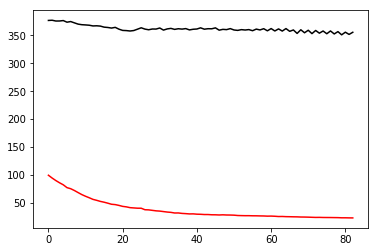

In [113]:
lower=20
plt.plot(valid_loss_list[lower:], color='black', label='validation loss')
plt.plot(train_loss_list[lower:], color='red', label='train loss')
plt.show()

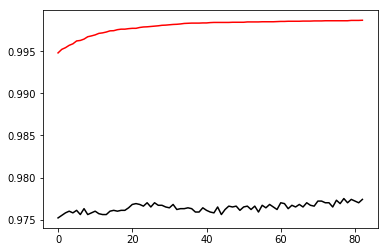

In [114]:
plt.plot(valid_accu_list[lower:], color='black', label='validation accuracy')
plt.plot(train_accu_list[lower:], color='red', label='train accuracy')
plt.show()

In [74]:
rand_batch=np.random.randint(train_num//batch_size)
grad_lr=train_batch(rand_batch,parameters)

In [95]:
lr_list=[]
lower=-2.75
upper=-0.75
step=0.1
for lr_pow in tqdm_notebook(np.linspace(lower,upper,num=(upper-lower)//step+1)):
    learn_rate=10**lr_pow
    parameters_tmp=combine_parameters(parameters,grad_lr,learn_rate)
    train_loss_tmp=train_loss(parameters_tmp)
    lr_list.append([lr_pow,train_loss_tmp])

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


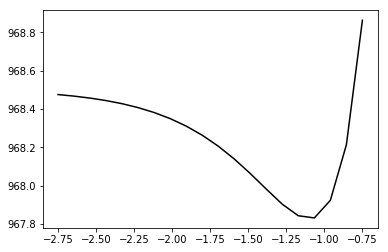

In [96]:
upper=len(lr_list)
plt.plot(np.array(lr_list)[:upper,0],np.array(lr_list)[:upper,1], color='black')
plt.show()

In [108]:
path='modelv2_01.pkl'
with open(path,'rb') as f:
    (parameters,
        current_epoch,
        train_loss_list,
        valid_loss_list,
        train_accu_list,
        valid_accu_list
    )=pickle.load(f)